<a href="https://colab.research.google.com/github/MustafaBozkurt84/predictive-maintanance-LSTM/blob/master/MultivariateTimeSeriesLSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# Setting seed for reproducibility
np.random.seed(1234)  
PYTHONHASHSEED = 0
from matplotlib import pyplot
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, recall_score, precision_score
from keras.models import Sequential,load_model
from keras.layers import Dense, Dropout, LSTM


##################################
# Data Ingestion
##################################

# read training data - It is the aircraft engine run-to-failure data.
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [28]:
df = pd.read_excel("/content/drive/MyDrive/Datasets/predictive maintance /AnalizDataPM.xlsx",engine='openpyxl')
df["Time"]= [str(i).replace("2020-02-02","2/2/2020").replace("2020-01-02","2/1/2020") for i in df["Time"]]
df['Time'] = pd.to_datetime(df['Time']) 
df['Time']=[str(i).split(":")[0] for i in df["Time"]]
df['Time'] = pd.to_datetime(df['Time'],format="%Y-%m-%d %H") #%Y-%m-%d %H:%M:%S
df=df.groupby("Time").mean()
df.reset_index(inplace=True)
df.to_csv("/content/drive/MyDrive/Datasets/predictive maintance /DataAnaliz.csv")
df.head()

KeyboardInterrupt: ignored

In [103]:
df=pd.read_csv("/content/drive/MyDrive/Datasets/predictive maintance /DataAnaliz.csv")
df['Time'] = pd.to_datetime(df['Time'],format="%Y-%m-%d %H") #%Y-%m-%d %H:%M:%S
df=df.iloc[:,0:]
df

,Time,vibx,vibz,temp,zacc,crest,zfreq
0,2020-01-17 00:00:00,1.208404,0.968665,29.501891,0.260534,3.817392,0.070044
1,2020-01-17 01:00:00,1.173835,1.045636,29.352279,0.262390,3.857893,0.069983
2,2020-01-17 02:00:00,1.161203,0.959516,29.187751,0.259026,3.811876,0.069978
3,2020-01-17 03:00:00,1.191830,0.957197,29.630256,0.260562,3.833699,0.070006
4,2020-01-17 04:00:00,1.027394,0.860651,30.167650,0.231498,4.164031,0.060902
...,...,...,...,...,...,...,...
395,2020-02-02 14:00:00,0.165436,0.155614,16.767343,0.092335,8.327532,0.010000
396,2020-02-02 15:00:00,0.203813,0.173919,16.581073,0.103380,8.316859,0.011656
397,2020-02-02 16:00:00,2.264839,1.148385,20.762806,0.550969,4.669187,0.117801
398,2020-02-02 17:00:00,1.853924,0.940645,26.438105,0.378305,3.659111,0.103263


In [104]:
fail_time =df[df["Time"]=="2020-01-27 14:00:00"].index[0]

In [105]:
df['Hour'] = df['Time'].apply(lambda time: time.hour)
df['Month'] = df['Time'].apply(lambda time: time.month)
df['Day of Week'] = df['Time'].apply(lambda time: time.dayofweek)
df['Year'] = df['Time'].apply(lambda t: t.year)
df=pd.get_dummies(df,columns=['Hour','Month','Day of Week','Year'],drop_first=True)

for col in df.columns[1:7]:
  for i in range(1,4):
      df['lag_'+str(i)+col] = df[col].shift(i)
for col in df.columns[1:7]:
  df[col+'expanding_mean'] = df[col].expanding(5).mean()
  df[col+'expanding_std'] = df[col].expanding(5).std()
df.dropna(axis=0,inplace=True)

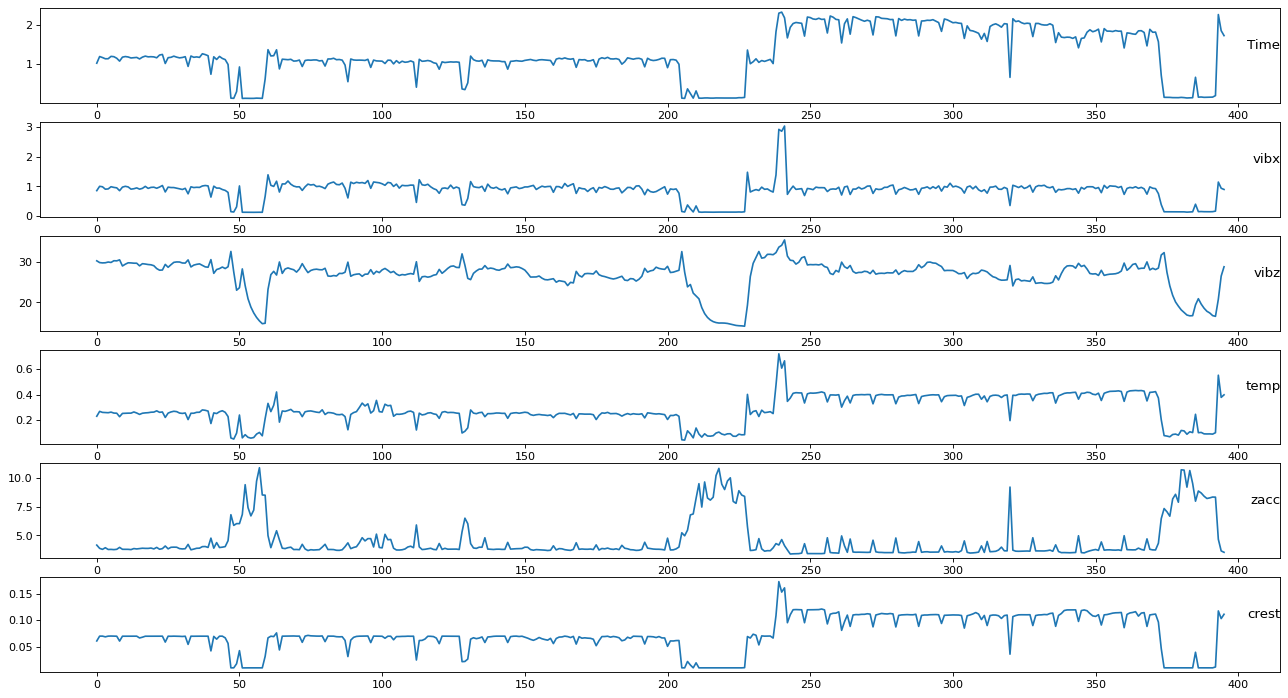

In [106]:

values = df.iloc[:,1:].values
# specify columns to plot
groups = [0,1, 2, 3, 4,5]
i = 1
# plot each column
pyplot.figure(figsize=(20, 11), dpi=80)
for group in groups:
	pyplot.subplot(len(groups), 1, i)
	pyplot.plot(values[:, group])
	pyplot.title(df.columns[group], y=0.5, loc='right')
	i += 1
pyplot.show()

In [107]:
# prepare data for lstm
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
 
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg
 

In [108]:
values = df.iloc[:,1:].values
# integer encode direction
#encoder = LabelEncoder()
#values[:,4] = encoder.fit_transform(values[:,4])
# ensure all data is float
values = values.astype('float32')
# normalize features
#scaler = MinMaxScaler(feature_range=(0, 1))
#scaled = scaler.fit_transform(values)
scaled=values
# specify the number of lag hours
n_hours = 3
n_features = 6
# frame as supervised learning
reframed = series_to_supervised(scaled, n_hours, 1)
print(reframed.shape)
 
# split into train and test sets
values = reframed.values
n_train_hours = 192
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
n_obs = n_hours * n_features
train_X, train_y = train[:, :n_obs], train[:, -n_features]
test_X, test_y = test[:, :n_obs], test[:, -n_features]
print(train_X.shape, len(train_X), train_y.shape)
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_hours, n_features))
test_X = test_X.reshape((test_X.shape[0], n_hours, n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)
 

(393, 264)
(192, 18) 192 (192,)
(192, 3, 6) (192,) (201, 3, 6) (201,)


In [109]:
train.shape

(192, 264)

Epoch 1/50
3/3 - 2s - loss: 0.5669 - val_loss: 0.4532
Epoch 2/50
3/3 - 0s - loss: 0.3880 - val_loss: 0.2780
Epoch 3/50
3/3 - 0s - loss: 0.2114 - val_loss: 0.1037
Epoch 4/50
3/3 - 0s - loss: 0.0553 - val_loss: 0.0608
Epoch 5/50
3/3 - 0s - loss: 0.0933 - val_loss: 0.0990
Epoch 6/50
3/3 - 0s - loss: 0.1133 - val_loss: 0.0721
Epoch 7/50
3/3 - 0s - loss: 0.0702 - val_loss: 0.0254
Epoch 8/50
3/3 - 0s - loss: 0.0170 - val_loss: 0.0620
Epoch 9/50
3/3 - 0s - loss: 0.0509 - val_loss: 0.0674
Epoch 10/50
3/3 - 0s - loss: 0.0428 - val_loss: 0.0320
Epoch 11/50
3/3 - 0s - loss: 0.0206 - val_loss: 0.0245
Epoch 12/50
3/3 - 0s - loss: 0.0275 - val_loss: 0.0221
Epoch 13/50
3/3 - 0s - loss: 0.0134 - val_loss: 0.0334
Epoch 14/50
3/3 - 0s - loss: 0.0226 - val_loss: 0.0397
Epoch 15/50
3/3 - 0s - loss: 0.0195 - val_loss: 0.0205
Epoch 16/50
3/3 - 0s - loss: 0.0177 - val_loss: 0.0192
Epoch 17/50
3/3 - 0s - loss: 0.0133 - val_loss: 0.0246
Epoch 18/50
3/3 - 0s - loss: 0.0146 - val_loss: 0.0305
Epoch 19/50
3/3 - 0

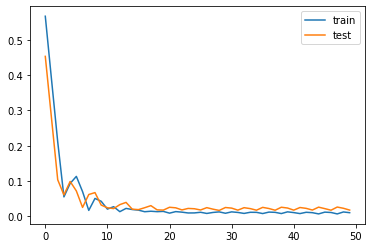

In [110]:
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [111]:
# make a prediction
yhat = model.predict(test_X)

In [117]:
from numpy import concatenate
from math import sqrt
from sklearn.metrics import mean_squared_error

test_X = test_X.reshape((test_X.shape[0], n_hours*n_features))
# invert scaling for forecast
inv_yhat1 = concatenate((yhat, test_X[:, -3:]), axis=1)
#inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat1[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, -7:]), axis=1)
#inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 0.023


Test RMSE: 0.023
Test RMSE: 0.291
Test RMSE: 0.291
Test RMSE: 0.299


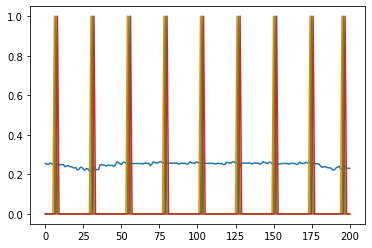

In [116]:
for i in range(4):
    inv_yhat = inv_yhat1[:,i]
    # invert scaling for actual
    test_y = test_y.reshape((len(test_y), 1))
    inv_y = concatenate((test_y, test_X[:, -7:]), axis=1)
    #inv_y = scaler.inverse_transform(inv_y)
    inv_y = inv_y[:,i]
    # calculate RMSE
    rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
    print('Test RMSE: %.3f' % rmse)
    pyplot.plot(inv_yhat)

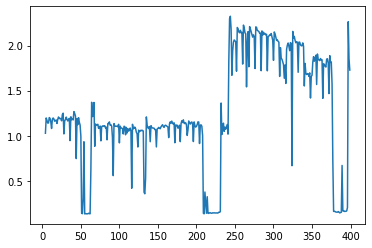

In [118]:
pyplot.plot(df.iloc[:,1])